In [1]:
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# read all csv files in Datasets/Gasolina folder
files = glob.glob('Datasets/Gasolina/*.csv')
dfs = [pd.read_csv(file) for file in files]
gasolina = pd.concat(dfs, ignore_index=True)
gasolina["Fuel"] = 1

# read all csv files in Datasets/Etanol folder
files = glob.glob('Datasets/Etanol/*.csv')
dfs = [pd.read_csv(file) for file in files]
etanol = pd.concat(dfs, ignore_index=True)
etanol["Fuel"] = 0

# concat all dataframes
df = pd.concat([gasolina, etanol], ignore_index=True)

In [ ]:
import numpy as np
import ast

# Função para garantir que a entrada seja um dicionário
def convert_to_dict(sensor_data):
    if isinstance(sensor_data, str):
        try:
            return ast.literal_eval(sensor_data)
        except (ValueError, SyntaxError):
            return {}
    elif isinstance(sensor_data, dict):
        return sensor_data
    else:
        return {}

# Converter todos os elementos para dicionários
df['othersensors'] = df['othersensors'].apply(convert_to_dict)

# Função para extrair 'timingAdvance' ou retornar NaN se não estiver presente
def get_etanol_percentage(sensor_data):
    return sensor_data.get('ethanolPercentage', np.nan)

# Aplicando a função para criar uma nova coluna 'ethanolPercentage'
df['ethanolPercentage'] = df['othersensors'].apply(get_etanol_percentage)

In [9]:
# df = df[["Ethanol Fuel %(%)", "Fuel"]]
df = df[["Ethanol Fuel %(%)", "Speed (OBD)(km/h)", "Engine RPM(rpm)", "Engine Load(%)", "Throttle Position(Manifold)(%)", "Timing Advance(°)", "Fuel"]]

In [10]:
df.shape

(71180, 7)

In [11]:
df.Fuel.value_counts()

Fuel
0    40291
1    30889
Name: count, dtype: int64

In [12]:
# split dataset into training and test sets
X = df.drop("Fuel", axis=1)
# X["Ethanol Fuel %(%)"] = mean_ethanol
y = df["Fuel"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8073
           1       1.00      1.00      1.00      6163

    accuracy                           1.00     14236
   macro avg       1.00      1.00      1.00     14236
weighted avg       1.00      1.00      1.00     14236



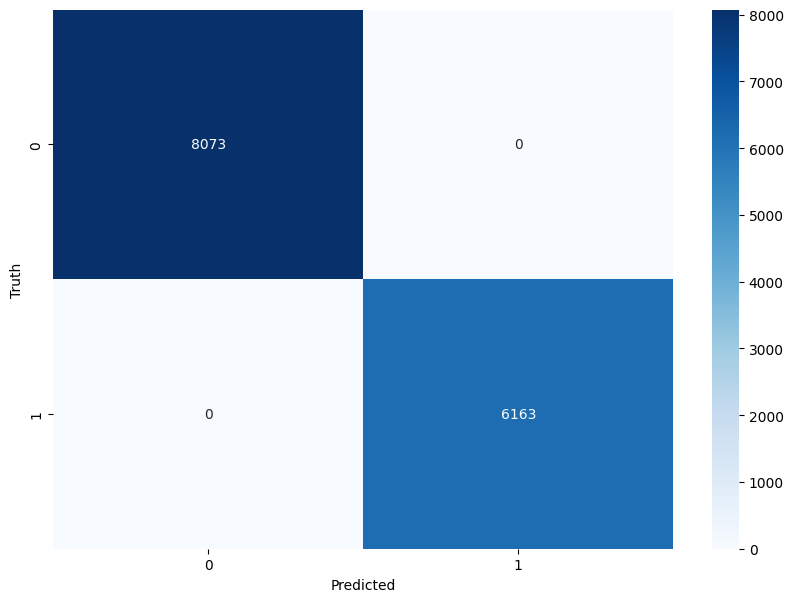

In [31]:
# plot confusion matrix
cm = confusion_matrix(y_test, predictions)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()

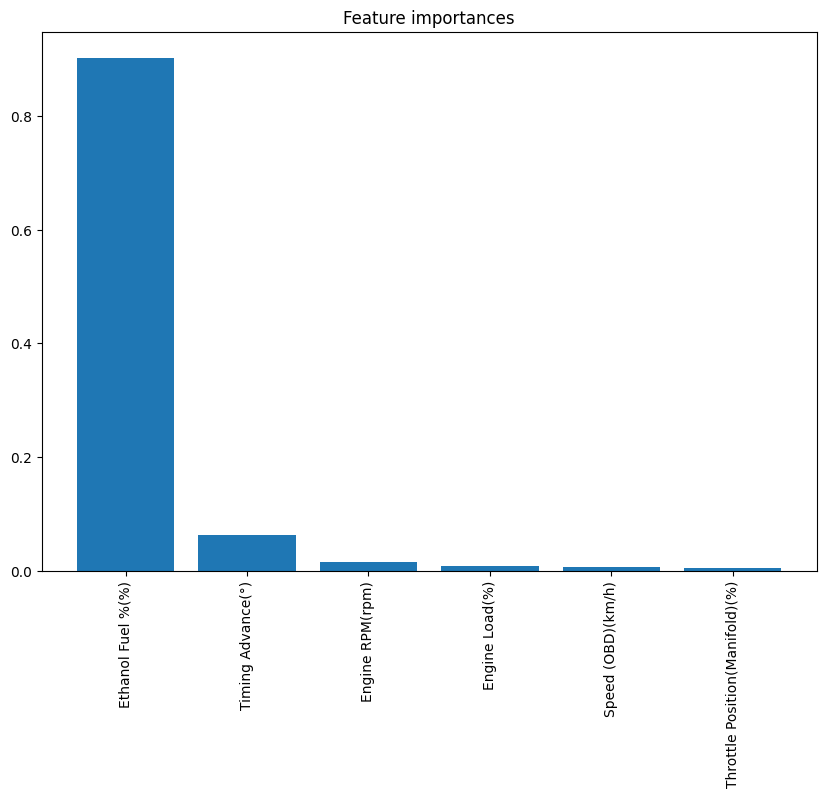

In [30]:
# plot featyre importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 7))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()

In [14]:
X_test.to_csv("./Datasets/X_test.csv", index=False)

In [16]:
!pip install micromlgen>=1.1.26

In [17]:
from micromlgen import port, port_testset

# write the model to a file
with open("model_rf.h", "w") as file:
    file.write(port(rf, classmap={0: "Etanol", 1: "Gasolina"}))

file_size = (os.path.getsize("model_rf.h")) / 1024
print(f"Model size: {file_size} KB")


Model size: 3052.095703125 KB


## C++ model evaluation

In [27]:
y_pred_test = pd.read_csv("./output_test.csv", header=None)
y_pred_test

,0
0,0
1,1
2,0
3,1
4,0
...,...
14231,0
14232,0
14233,1
14234,0


In [25]:
y_test

65298    0
20934    1
44579    0
28838    1
56201    0
        ..
61485    0
56538    0
17904    1
60471    0
8943     1
Name: Fuel, Length: 14236, dtype: int64

In [28]:
# plot classification report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8073
           1       1.00      1.00      1.00      6163

    accuracy                           1.00     14236
   macro avg       1.00      1.00      1.00     14236
weighted avg       1.00      1.00      1.00     14236



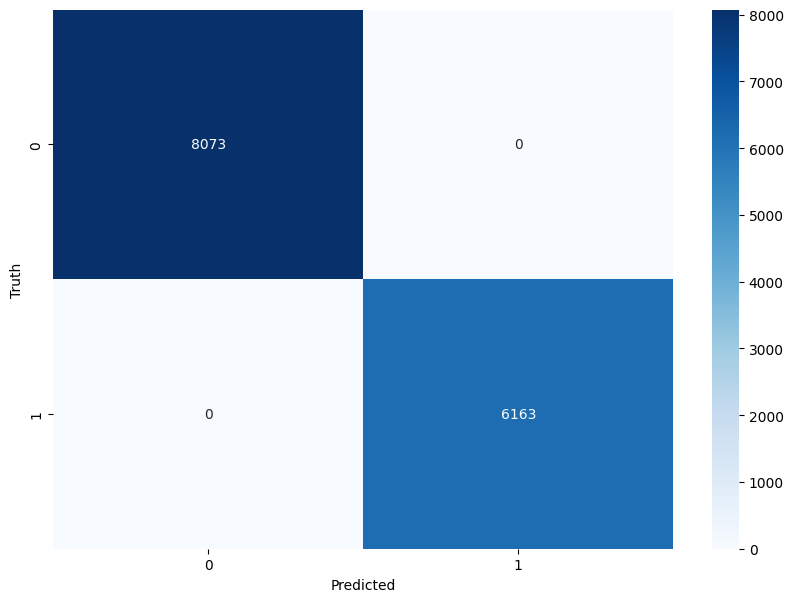

In [32]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()